# Explicit time integration with user-defined methods

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- solving ordinary differential equations with your own methods
- custom eighth-order Runge-Kutta method
- coding up a second-order Adams-Bashforth method for use in Spitfire

## Introduction

In previous demonstrations you've seen the basics of using Spitfire's `odesolve` method.
The abstraction of time integration techniques in `odesolve` makes it possible for you to "plug in" methods defined entirely in your own code, which is the focal point of this notebook.

Two ways of building your own time-stepping methods are covered:
1. Using the `GeneralAdaptiveERK` class in `spitfire.time.methods` to provide Butcher coefficients for general, explicit Runge-Kutta methods (possibly with error-based adaptive time-stepping)
2. Writing your own `Method` classes for a `Governor` instance

We will use the first option to build some Runge-Kutta methods, and we will show how the second method can actually enable the use of [Adams-Bashforth methods](https://en.wikipedia.org/wiki/Linear_multistep_method) not provided by Spitfire.

## Custom Runge-Kutta methods with `GeneralAdaptiveERK`

This class allows you to define the [Butcher tableau](https://en.wikipedia.org/wiki/Runge–Kutta_methods) for any explicit Runge-Kutta method. Below we first build the Forward Euler method and then a more interesting example - the two-stage, second-order method of Ralston.

In [1]:
import numpy as np
from spitfire import GeneralAdaptiveERK as GERK

runge_kutta_methods = dict()

runge_kutta_methods['Forward Euler'] = GERK(name='Forward Euler',
                                            A=np.array([[0.]]),
                                            b=np.array([1.]),
                                            order=1)
runge_kutta_methods['Ralston'] = GERK(name='Ralston',
                                      A=np.array([[0., 0.],
                                               [2. / 3., 0.]]),
                                      b=np.array([0.25, 0.75]),
                                      order=2)

Just for some extra fun we now make an eighth-order method with thirteen stages.

In [2]:
runge_kutta_methods['Fehlberg'] = GERK(name='Fehlberg',
                                       A=np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                   [2. / 27., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                   [1. / 36., 1. / 12., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                   [1. / 24, 0, 1. / 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                   [5. / 12., 0, -25. / 16., 25. / 16., 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                   [1. / 20., 0, 0, 1. / 4., 1. / 5., 0, 0, 0, 0, 0, 0, 0, 0],
                                                   [-25. / 108, 0, 0, 125. / 108., -65. / 27., 125. / 54., 0, 0, 0, 0, 0, 0, 0],
                                                   [31. / 300., 0, 0, 0, 61. / 225., -2. / 9., 13. / 900., 0, 0, 0, 0, 0, 0],
                                                   [2., 0, 0, -53. / 6., 704. / 45., -107. / 9., 67. / 90., 3., 0, 0, 0, 0, 0],
                                                   [-91. / 108., 0, 0, 23. / 108., -976. / 135., 311. / 54., -19. / 60., 17. / 6., -1. / 12., 0, 0, 0, 0],
                                                   [2383. / 4100., 0, 0, -341. / 164., 4496. / 1025., -301. / 82., 2133. / 4100., 45. / 82., 45. / 164., 18. / 41., 0, 0, 0],
                                                   [3. / 205., 0, 0, 0, 0, -6. / 41., -3. / 205., -3. / 41., 3. / 41., 6. / 41., 0, 0, 0],
                                                   [-1777. / 4100., 0, 0, -341. / 164., 4496. / 1025., -289. / 82., 2193. / 4100., 51. / 82., 33. / 164., 12. / 41., 0, 1., 0]]),
                                       b=np.array([0, 0, 0, 0, 0, 34. / 105., 9. / 35., 9. / 35., 9. / 280., 9. / 280., 0, 41. / 840., 41. / 840.]),
                                       order=8)

Now we can go ahead and solve the exponential decay problem from prior notebooks with each method.
Note how accurate the eighth-order method is compared to Forward Euler and the Ralston method.

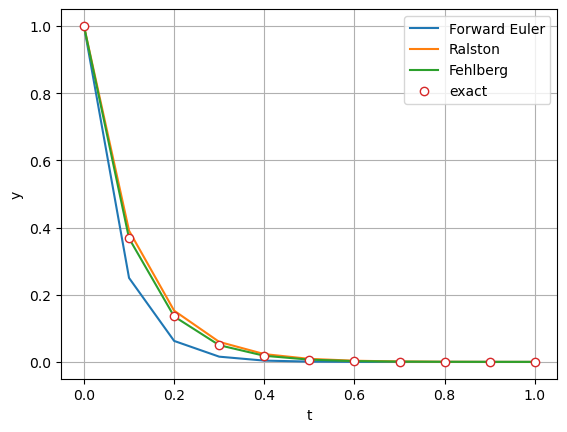

In [3]:
from spitfire import odesolve

import matplotlib.pyplot as plt

dt = 0.05
k = -10.
tf = 1.
y0 = np.array([1.])
rhs = lambda t, y: k * y

output_times = np.linspace(0., tf, 11)
y_exact = y0 * np.exp(k * output_times)

for name in runge_kutta_methods:
    y = odesolve(rhs, y0, output_times, step_size=dt, method=runge_kutta_methods[name])
    plt.plot(output_times, y, '-', label=name)

plt.plot(output_times, y_exact, 'o', markerfacecolor='w', label='exact')

plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid()
plt.show()

## Adams-Bashforth method with a custom class

Now we show how to write a new method that can be used in `odesolve`.
Spitfire doesn't provide linear multistep methods out of the box, but we can code up the second-order Adams-Bashforth method in twenty or so lines.
Our class derives from the `TimeStepperBase` class, to which it provides its name and order of accuracy in the `super().__init__` call (a base class constructor in Python).
Next, the `single_step` method is defined and written so that it returns a `StepOutput` object populated with the solution update ($y^{n+1}-y^{n}$).
And that's it.

The second-order [Adams-Bashforth method](https://en.wikipedia.org/wiki/Linear_multistep_method), referred to frequently as AB2, is a two-step method that uses the right-hand side at both the current time level and the prior one.
The next time level, with solution $y^{n+1}$, is computed with

$$ y^{n+1} = y^{n} + \frac{\Delta t}{2}\left(3 r(t^n,y^n) - r(t^{n-1},y^{n-1})\right) $$

where $r(t,y)$ is the right-hand side function of the differential equation.
This update can't be performed on the first time step and so we simply use the Forward Euler update $y^{n+1} = y^{n} + \Delta t r(t^n, y^n)$. This is not strictly accurate to second-order, but it works well enough in practice.

A key detail in implementing linear multistep methods is the challenge of handling a variable time step history.
We simply ignore this difficulty here, so the class below will only be correct for a fixed time step. We'll actually implement a variable step AB2 method in a following demonstration.

Note that custom time-stepper methods like this can return more information in `StepOutput`, such as error estimates for time step adaptativity, but that's a bit more advanced and we suggest interested developers check out the source code in the `spitfire.time.methods.py` file for more details.

In [4]:
from spitfire.time.methods import StepOutput, TimeStepperBase

class AdamsBashforth2(TimeStepperBase):
    def __init__(self):
        super().__init__(name='Adams-Bashforth-2', order=2)
        self._rhs_nm1 = None

    def single_step(self, state, t, dt, rhs, *args, **kwargs):
        rhs_n = rhs(t, state)
        if self._rhs_nm1 is None:
            update = dt * rhs_n   # if first step, use Forward Euler
        else:
            update = 0.5 * dt * (3. * rhs_n - self._rhs_nm1)
        self._rhs_nm1 = np.copy(rhs_n)    
        return StepOutput(solution_update=update)

Now this class may simply be provided to `odesolve` like any of the other methods we've used so far.

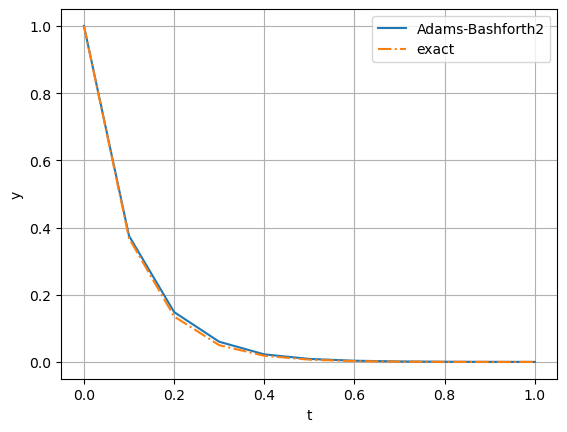

In [5]:
y_ab2 = odesolve(rhs, y0, output_times, step_size=dt, method=AdamsBashforth2())

plt.plot(output_times, y_ab2, '-', label='Adams-Bashforth2')
plt.plot(output_times, y_exact, '-.', label='exact')

plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid()
plt.show()

## Verification

To make sure that we coded our new Adams-Bashforth method correctly, we're going to verify by establishing its order of accuracy.
This consists of running simulations at different time step sizes and observing how the error (against an exact solution) decreases.
A first-order method will see a 10x decrease in error for a 10x decrease in the step size, while a second-order method would see a 100x decrease and a fourth order method would see a 10000x decrease.

To simplify this we define the `compute_error` method below that takes in a time-stepper method and a step size and returns the error in solving the exponential decay problem to a specified time.

In [6]:
def compute_error(method, time_step_size):
    tf = 0.5
    yf = odesolve(rhs, y0, np.array([tf]), step_size=time_step_size, method=method).ravel()
    return np.abs(yf - y0 * np.exp(k * tf))[0]

Now we import a few more methods provided by Spitfire for comparison's sake and run `compute_error` for each method across a range of time step sizes.
This uses a Python list comprehension to simplify the construction of the list of errors, and simply saves off the results in a dictionary.
This sort of pattern is really convenient in many uses of Spitfire.

Following this we use NumPy's `polyfit` function to obtain the slopes of the error over time step size results (in logarithmic scale). This shows that Spitfire's methods and our new second-order Adams-Bashforth method are all solving the problem to their design order of accuracy.

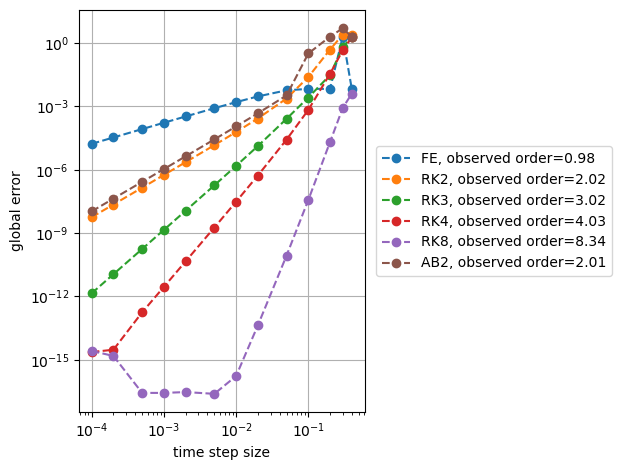

In [7]:
from spitfire import ForwardEulerS1P1, \
    RK4ClassicalS4P4, \
    ExpRalstonS2P2, \
    RK3KuttaS3P3

dt_list = [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 3e-1, 4e-1]

error_dict = dict()
error_dict['FE'] = [compute_error(ForwardEulerS1P1(), dt) for dt in dt_list]
error_dict['RK2'] = [compute_error(ExpRalstonS2P2(), dt) for dt in dt_list]
error_dict['RK3'] = [compute_error(RK3KuttaS3P3(), dt) for dt in dt_list]
error_dict['RK4'] = [compute_error(RK4ClassicalS4P4(), dt) for dt in dt_list]
error_dict['RK8'] = [compute_error(runge_kutta_methods['Fehlberg'], dt) for dt in dt_list]
error_dict['AB2'] = [compute_error(AdamsBashforth2(), dt) for dt in dt_list]

order_dict = dict()
for method in error_dict:
    # here we slice the results so that the polyfit is done only on the asymptotic data,
    # - some of the methods are unstable with dt > 0.1
    # - the RK8 method and RK4 method reach machine precision errors that cannot be lower
    if method == 'RK8':
        s = slice(6, 10, None)
    else:
        s = slice(2, 7, None)
    order_dict[method] = np.polyfit(np.log(dt_list[s]), np.log(error_dict[method][s]), 1)[0]

for method in error_dict:
    plt.loglog(dt_list, error_dict[method], 'o--', label=f'{method}, observed order={order_dict[method]:.2f}')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.xlabel('time step size')
plt.ylabel('global error')
plt.grid()
plt.tight_layout()
plt.show()

## Conclusions

In this example we've shown how to employ user-defined explicit Runge-Kutta methods and custom classes, in this a second-order Adams-Bashforth method, to solve a simple ordinary differential equation. Verifying the order of accuracy of the methods suggests confidence that they are implemented correctly.